###    Prevalence - Mortality - Table 2

In [25]:
import pandas as pd
from igraph import Graph
import igraph as ig
import os
import numpy as np 
import matplotlib.pyplot as plt


In [26]:
DATA_PATH = f"..{os.sep}data{os.sep}"
print(f"data path: {DATA_PATH}")

data path: ../data/


In [27]:

def create_graph(gender, type_, subfix):
    adj_path = f"{DATA_PATH}3.AdjacencyMatrices{os.sep}Adj_Matrix_{gender}_{type_}_{subfix}.csv"
    A = pd.read_csv(adj_path, sep=' ', header=None)
    
    if type_ == 'ICD':
        type_ = 'ICD10_Diagnoses'
    names_path = f"{DATA_PATH}{type_}_All.csv"
    df_names = pd.read_csv(names_path)#, index_col=0)
    
    if A.shape[0] != df_names.shape[0]:
        raise ValueError("Adjacency matrix size and names dataframe size do not match!")
    
    # Create graph from adjacency matrix
    # igraph expects edges as a list of tuples and weights as a separate list
    
    edges = []
    weights = []
    n = A.shape[0]
    for i in range(n):
        for j in range(n):
            w = A.iat[i, j]
            if w != 0:
                edges.append((i, j))
                weights.append(w)
    
    g = Graph(edges=edges, directed=False)  # or directed=True if your network is directed
    g.es['weight'] = weights
    
    # Add node attributes
    g.vs['id'] = df_names.index.tolist()
    
    if type_ == 'Chronic':
        name_col = 'label'
    elif type_ == 'ICD10_Diagnoses':
        name_col = 'icd_code'
    elif type_ == 'Block':
        name_col = 'block_name'
    else:
        raise ValueError(f"Unknown type: {type_}")
    
    g.vs['name'] = df_names[name_col].tolist()
    
    if type_ == 'ICD10_Diagnoses':
        # g.vs['description'] = df_names['descr'].tolist()
        icd_eng = pd.read_csv(f"{DATA_PATH}ICD10_Diagnoses_All_ENG.csv")
        #map descrpition to icd code
        icd_dict = icd_eng.set_index('Code')['ShortDescription'].to_dict()
        g.vs['description'] = [icd_dict.get(code, '') for code in g.vs['name']]
        
    if type_ == 'ICD10_Diagnoses' and 'age' in subfix:
        df_prev = pd.read_csv(f"{DATA_PATH}1.Prevalence{os.sep}Prevalence_Sex_Age_Year_ICD.csv")
        age_dict = {'age_1': '0-9', 'age_2': '10-19', 'age_3': '20-29', 
                    'age_4': '30-39', 'age_5': '40-49', 'age_6': '50-59', 
                    'age_7': '60-69', 'age_8': '70-79', 'age_9': '80+'}
        age_col = age_dict[subfix]
        df_prev = df_prev[(df_prev['Age_Group'] == age_col) & (df_prev['sex'] == gender) & (df_prev['year'] == 2014)]
        
        #assign to each icd code its prevalence
        prevalence_dict = df_prev.set_index('icd_code')['p'].to_dict()
        g.vs['prevalence'] = [prevalence_dict.get(code, 0) for code in g.vs['name']]
    
    return g

In [28]:
g = create_graph('Female', 'ICD', 'age_8')
ig.summary(g)

IGRAPH UNW- 1080 8362 -- 
+ attr: description (v), id (v), name (v), prevalence (v), weight (e)


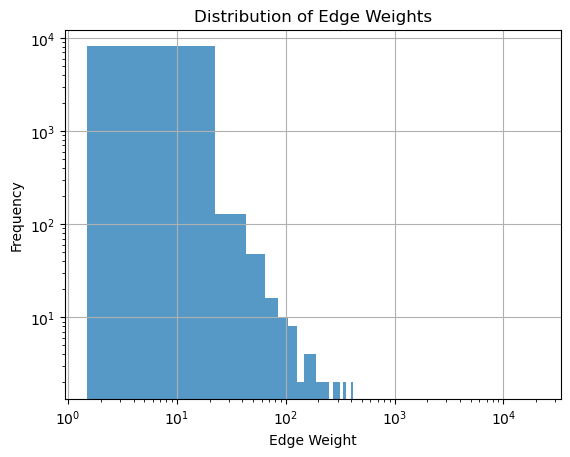

In [29]:
def plot_edge_weights_distribution(g):
    edge_weights = g.es['weight']
    plt.hist(edge_weights, bins=1000, alpha=0.75,histtype='bar')
    plt.xlabel('Edge Weight')
    plt.ylabel('Frequency')
    plt.title('Distribution of Edge Weights')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.show()
    
plot_edge_weights_distribution(g)

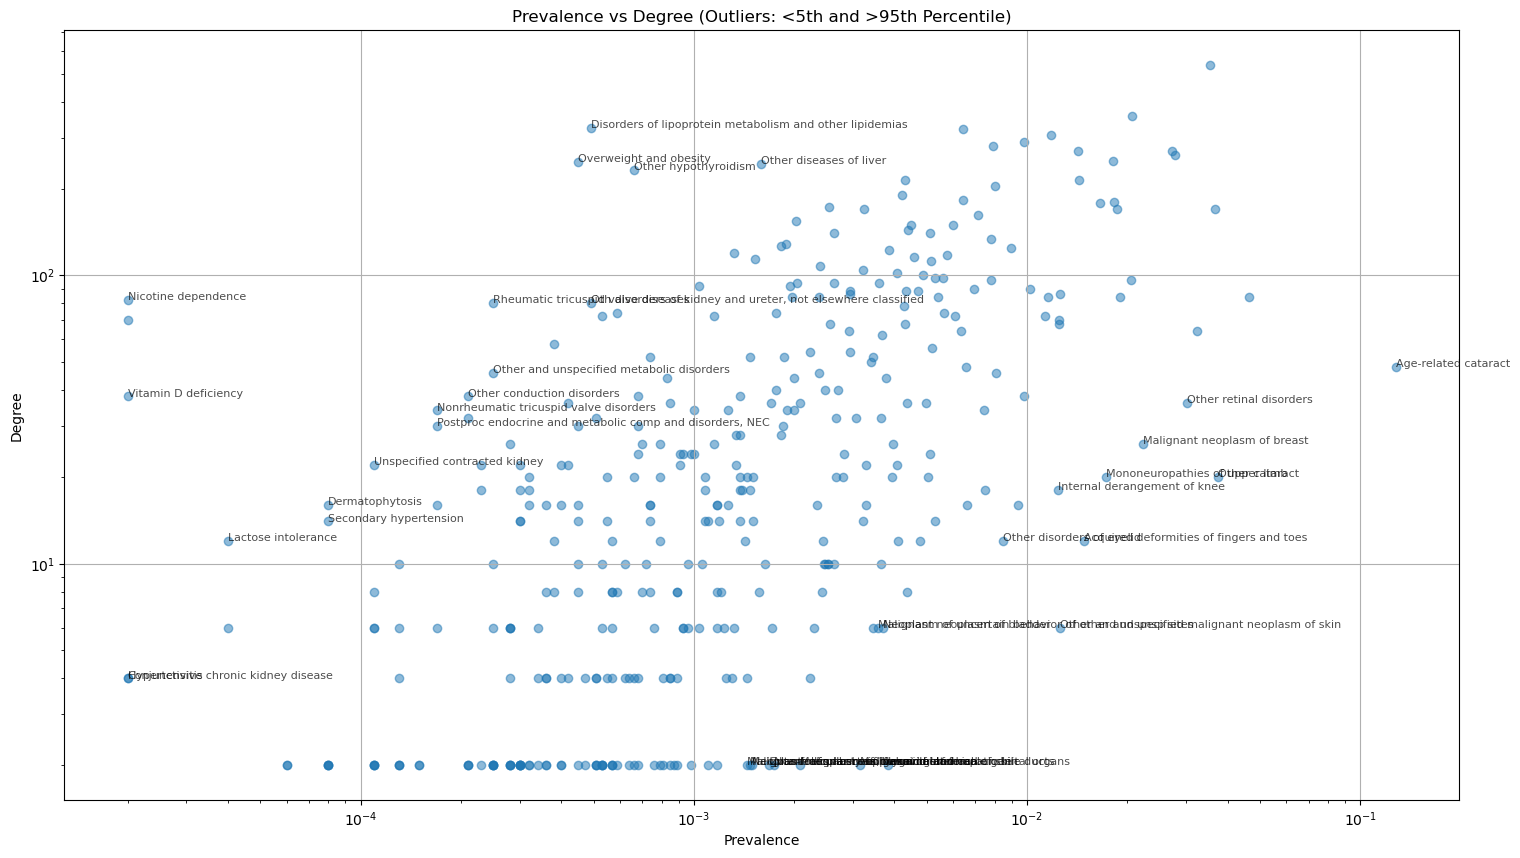

In [30]:
def plot_prevalence_vs_degree(g):
    # Extract data
    degrees = np.array(g.degree())
    prevalence = np.array(g.vs['prevalence'])
    descriptions = np.array(g.vs['description'])
        
    # 1. Create a mask for valid data
    # We only want indices where prevalence > 0 AND degree > 0
    # (Prevalence=0 causes divide-by-zero; Degree=0 causes log(0)=-inf)
    valid_mask = (prevalence > 0) & (degrees > 0)
    
    # 2. Filter arrays to keep only valid data for calculation
    # We will use these 'clean' arrays to calculate percentiles
    d_clean = degrees[valid_mask]
    p_clean = prevalence[valid_mask]
    
    # 3. Calculate Log-Ratios on clean data
    log_ratios_clean = np.log(d_clean / p_clean)
    
    # 4. Calculate Dynamic Thresholds (Percentiles) based on valid data
    lower_bound = np.percentile(log_ratios_clean, 5)
    upper_bound = np.percentile(log_ratios_clean, 95)
    
    # 5. Identify Outliers
    outliers = []
    
    # We iterate through ALL nodes, but only check valid ones
    for i in range(len(degrees)):
        if not valid_mask[i]:
            continue # Skip invalid nodes
            
        # Calculate ratio for this specific node
        current_log_ratio = np.log(degrees[i] / prevalence[i])
        
        # Check against thresholds
        if current_log_ratio < lower_bound or current_log_ratio > upper_bound:
            outliers.append(i)
            
    # --- Plotting ---
    plt.figure(figsize=(18, 10))
    
    plt.scatter(prevalence, degrees, alpha=0.5)
    
    for i in outliers:
        plt.annotate(descriptions[i], (prevalence[i], degrees[i]), fontsize=8, alpha=0.7)
        
    plt.ylabel('Degree')
    plt.xlabel('Prevalence')
    plt.title('Prevalence vs Degree (Outliers: <5th and >95th Percentile)')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.show()
 
plot_prevalence_vs_degree(g)

In [31]:
def deg_prev_df():
    # Added new columns to the schema
    columns = ['Sex', 'Age_Group', 'ICD_Code', 'ICD_Description', 
               'Degree', 'Prevalence', 'Log_Ratio', 'Outlier']
    df = pd.DataFrame(columns=columns)
    
    for gender in ['Male', 'Female']:
        for a in ['1', '2', '3', '4', '5', '6', '7', '8']:
            age = f'age_{a}'

            print('Loading ' + gender + ' ' + age)
            g = create_graph(gender, 'ICD', age)
            
            icd_codes = g.vs['name']
            icd_desc = g.vs['description']
            
            # Convert to numpy arrays for efficient math
            degrees = np.array(g.degree())
            prevalence = np.array(g.vs['prevalence'])
            
            # Create the temporary DataFrame for this specific group
            temp_df = pd.DataFrame({
                'Sex': gender,
                'Age_Group': age,
                'ICD_Code': icd_codes,
                'ICD_Description': icd_desc,
                'Degree': degrees,
                'Prevalence': prevalence
            })
                        
            # 1. Initialize new columns with default values
            temp_df['Log_Ratio'] = np.nan
            temp_df['Outlier'] = False
            
            # 2. Create a mask to handle zeros safely (avoid divide-by-zero or log(0) errors)
            valid_mask = (temp_df['Degree'] > 0) & (temp_df['Prevalence'] > 0)
            
            # 3. Perform calculations only on valid rows
            if valid_mask.any():
                # Calculate Log Ratio: log(Degree / Prevalence)
                valid_ratios = np.log(
                    temp_df.loc[valid_mask, 'Degree'] / temp_df.loc[valid_mask, 'Prevalence']
                )
                temp_df.loc[valid_mask, 'Log_Ratio'] = valid_ratios
                
                # Calculate Percentiles for THIS specific Age Group & Sex
                lower_bound = np.percentile(valid_ratios, 5)
                upper_bound = np.percentile(valid_ratios, 95)
                
                # Determine Outliers (Below 5th percentile OR Above 95th percentile)
                outlier_mask = (valid_ratios < lower_bound) | (valid_ratios > upper_bound)
                temp_df.loc[valid_mask, 'Outlier'] = outlier_mask
                            
            df = pd.concat([df, temp_df], ignore_index=True)
    
    return df

In [32]:
deg_prev_df = deg_prev_df()

Loading Male age_1


/tmp/ipykernel_22630/2697712425.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp_df], ignore_index=True)


Loading Male age_2
Loading Male age_3
Loading Male age_4
Loading Male age_5
Loading Male age_6
Loading Male age_7
Loading Male age_8
Loading Female age_1
Loading Female age_2
Loading Female age_3
Loading Female age_4
Loading Female age_5
Loading Female age_6
Loading Female age_7
Loading Female age_8


In [33]:
deg_prev_df

,Sex,Age_Group,ICD_Code,ICD_Description,Degree,Prevalence,Log_Ratio,Outlier
0,Male,age_1,A00,Cholera,0,0.00000,NaN,False
1,Male,age_1,A01,Typhoid and paratyphoid fevers,0,0.00000,NaN,False
2,Male,age_1,A02,Other salmonella infections,2,0.00172,7.058578,False
3,Male,age_1,A03,Shigellosis,0,0.00003,NaN,False
4,Male,age_1,A04,Other bacterial intestinal infections,6,0.00402,7.308233,False
...,...,...,...,...,...,...,...,...
17030,Female,age_8,N95,Menopausal and other perimenopausal disorders,12,0.00476,7.832414,False
17031,Female,age_8,N96,Recurrent pregnancy loss,0,0.00000,NaN,False
17032,Female,age_8,N97,Female infertility,0,0.00000,NaN,False
17033,Female,age_8,N98,Complications associated with artificial ferti...,0,0.00000,NaN,False


In [34]:
import pandas as pd

def print_outlier_mortality_intersections(df_outliers, female_csv_path, male_csv_path):
    """
    Identifies and prints ONLY the ICD codes of outliers that have a mortality rate > 0.
    
    Args:
        df_outliers (pd.DataFrame): The dataframe returned by deg_prev_df() containing 'Outlier' column.
        female_csv_path (str): Path to 'mortality_diag_Female.csv'.
        male_csv_path (str): Path to 'mortality_diag_Male.csv'.
    """
    
    # 1. Load the Mortality CSVs
    mort_female = pd.read_csv(female_csv_path)
    mort_male = pd.read_csv(male_csv_path)
    
    # 2. Standardize Column Names for Merging
    # Rename 'icd_code' to 'ICD_Code' to match the dataframe, and 'age_10' to 'Age_Numeric'
    mort_female.rename(columns={'icd_code': 'ICD_Code', 'age_10': 'Age_Numeric'}, inplace=True)
    mort_male.rename(columns={'icd_code': 'ICD_Code', 'age_10': 'Age_Numeric'}, inplace=True)
    
    # 3. Filter the main DataFrame to get ONLY the outliers
    outliers_only = df_outliers[df_outliers['Outlier'] == True].copy()
    
    # 4. Iterate through Sex and Age Groups
    for gender in ['Female', 'Male']:
        # Select the correct mortality table based on gender
        if gender == 'Female':
            current_mort_df = mort_female
        else:
            current_mort_df = mort_male
            
        print(f"\n{'='*20}")
        print(f"{gender.upper()}")
        print(f"{'='*20}")

        for i in range(1, 9): # age_1 to age_8
            age_str = f'age_{i}'
            age_num = i
            
            # A. Get outliers for this specific group
            group_outliers = outliers_only[
                (outliers_only['Sex'] == gender) & 
                (outliers_only['Age_Group'] == age_str)
            ]
            
            # B. Get mortality records for this specific age
            group_mortality = current_mort_df[current_mort_df['Age_Numeric'] == age_num]
            
            # C. Join (Intersection)
            intersection = pd.merge(
                group_outliers[['ICD_Code']], # We only need the code now
                group_mortality[['ICD_Code', 'mortality']], 
                on='ICD_Code', 
                how='inner'
            )
            
            # D. Filter: Keep ONLY rows where mortality > 0
            intersection_filtered = intersection[intersection['mortality'] > 0]
            
            # E. Print ONLY the ICD Codes
            if not intersection_filtered.empty:
                print(f"\nAge {i}:")
                # Print just the list of codes
                for code in intersection_filtered['ICD_Code'].unique():
                    print(code)

In [35]:
print_outlier_mortality_intersections(df_outliers=deg_prev_df,
                                      female_csv_path="giovanni/mortality_diag_Female.csv",
                                      male_csv_path="giovanni/mortality_diag_Male.csv")


FEMALE

Age 1:
A04
A08
A09
B37
D50
H52
J90
K40

Age 2:
A09
K52

Age 3:
A09
B18
E03
F17
G35
J35
K59

Age 4:
B18
B37
D06
E03
E78
F17
G35
K35
K76

Age 5:
B37
C43
C50
D06
D17
E03
E74
E78
F17
H02
H52
I11
I64
I83
J38
J43
K76
M41
N20
N92

Age 6:
B37
C50
D17
D48
D63
E03
E55
E78
E79
E89
F17
G56
H02
I07
I27
I34
I64
I83
J43
K76
M65
M70
N20
N28
N64
N84
N95

Age 7:
C16
C44
C50
C67
C82
C83
D17
E03
E55
E66
E73
E78
E79
E89
F17
G54
H02
H10
H25
H26
H54
I07
I64
I66
I83
J30
K40
K76
M62
M72
N08
N10
N28
N81
N95

Age 8:
B35
C16
C22
C43
C44
C50
C67
C73
C83
D39
D48
E03
E55
E66
E73
E78
E88
E89
F17
G56
H02
H10
H25
H26
H35
I07
I12
I15
I36
I45
I64
K40
K76
L02
M20
N26
N28

MALE

Age 1:
A09
B37
D50
E10
H10
J35
K35
K40

Age 2:
A08
E78
F13

Age 3:
B17
B18
F14
F17
J93
K35

Age 4:
B17
E03
E78
E79
F14
F17
H81
H91
I11
I83
K35
K59
K70

Age 5:
B17
B18
C67
D48
D53
D63
E03
E78
E79
F12
F17
G47
G56
I12
I64
I83
J38
K35
K40
K61
K71
K76
M41
M77
N20
N43
N45
N47

Age 6:
B35
C43
D40
D48
D63
D69
E03
E72
E78
E79
F17
F54
G35
G47
H02
H1

In [ ]:


def get_outlier_counts(df):
    """
    Calculates and prints the raw number of outliers found in each age group 
    and sex.
    
    Args:
        df (pd.DataFrame): The dataframe returned by deg_prev_df() containing 
                           'Outlier', 'Sex', and 'Age_Group' columns.
    """
    # 1. Filter for Outliers
    outliers_only = df[df['Outlier'] == True]
    
    # 2. Aggregate Counts
    # Group by Sex and Age_Group and count the number of rows (size)
    counts = outliers_only.groupby(['Sex', 'Age_Group']).size().reset_index(name='Count')
    
    # 3. Define Age Label Mapping (for readability)
    age_mapping = {
        'age_1': '0-9',   'age_2': '10-19', 'age_3': '20-29', 'age_4': '30-39',
        'age_5': '40-49', 'age_6': '50-59', 'age_7': '60-69', 'age_8': '70-79'
    }
    counts['Age_Label'] = counts['Age_Group'].map(age_mapping)
    
    # 4. Sort for consistent output
    counts.sort_values(['Sex', 'Age_Group'], inplace=True)
    
    # 5. Print Raw Numbers
    print(f"{'Sex':<10} | {'Age Group':<10} | {'Outlier Count':<15}")
    print("-" * 40)
    
    for _, row in counts.iterrows():
        print(f"{row['Sex']:<10} | {row['Age_Label']:<10} | {row['Count']:<15}")
        
    return counts


get_outlier_counts(deg_prev_df)

Sex        | Age Group  | Outlier Count  
----------------------------------------
Female     | 0-9        | 12             
Female     | 10-19      | 11             
Female     | 20-29      | 16             
Female     | 30-39      | 20             
Female     | 40-49      | 30             
Female     | 50-59      | 34             
Female     | 60-69      | 38             
Female     | 70-79      | 38             
Male       | 0-9        | 14             
Male       | 10-19      | 10             
Male       | 20-29      | 14             
Male       | 30-39      | 22             
Male       | 40-49      | 32             
Male       | 50-59      | 38             
Male       | 60-69      | 38             
Male       | 70-79      | 36             


,Sex,Age_Group,Count,Age_Label
0,Female,age_1,12,0-9
1,Female,age_2,11,10-19
2,Female,age_3,16,20-29
3,Female,age_4,20,30-39
4,Female,age_5,30,40-49
5,Female,age_6,34,50-59
6,Female,age_7,38,60-69
7,Female,age_8,38,70-79
8,Male,age_1,14,0-9
9,Male,age_2,10,10-19
